#Demo day Fintech 8

"Data tersebut terkait dengan kampanye pemasaran langsung dari lembaga perbankan Portugis. Kampanye pemasaran didasarkan pada panggilan telepon. Seringkali, lebih dari satu kontak ke klien yang sama diperlukan, untuk mengakses apakah produk (deposito berjangka bank) akan ('ya') atau tidak ('tidak') dilanggan oleh pelanggan atau tidak. Folder data berisi dua kumpulan data: -

     train.csv: 45.211 baris dan 18 kolom diurutkan berdasarkan tanggal (dari Mei 2008 hingga November 2010)
     test.csv: 4521 baris dan 18 kolom dengan 10% contoh (4521), dipilih secara acak dari train.csv"

test pull and push

##Setup

In [1]:
import pathlib
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from google.colab import data_table
import tensorflow as tf
from sklearn.metrics import confusion_matrix

##Function

function split data

In [2]:
def dataframe_split(data, ratio= 0.2, shuffle= 0):
  len_ = int(len(data) - (ratio*len(data)))
  if shuffle == 0 :
    part_  = data.iloc[:int(1 + len_)]
    rest_part_ = data.drop(part_.index)
  elif shuffle == 1:
    part_ = data.sample(frac = 1.0 - ratio)
    rest_part_ = data.drop(part_.index)
  return (part_, rest_part_)

fucntion membuat dataset

In [3]:
def dataframe_to_dataset(data, batch_size=32):
  df = data.copy()
  labels = df.pop('target')
  df = {key:  tf.expand_dims(value,axis=1) for key, value in df.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [4]:
def dataframe_imbalanced_to_dataset(data, batch_size=32, repeat=1):
  no_df = data.loc[data['target'].eq(0)].copy()
  yes_df = data.loc[data['target'].eq(1)].copy()
  no_labels = no_df.pop('target')
  yes_labels = yes_df.pop('target')
  len_no_labels = len(no_labels)
  len_yes_labels = len(yes_labels)
  if len_no_labels > len_yes_labels:
    oversampling = int(round(len_no_labels/len_yes_labels, 0))
  else:
    oversampling = int(round(len_yes_labels/len_no_labels, 0))

  no_df = {key:  tf.expand_dims(value,axis=1) for key, value in no_df.items()}
  no_ds = tf.data.Dataset.from_tensor_slices((dict(no_df), no_labels))
  no_ds = no_ds.shuffle(batch_size).repeat(repeat)

  yes_df = {key:  tf.expand_dims(value,axis=1) for key, value in yes_df.items()}
  yes_ds = tf.data.Dataset.from_tensor_slices((dict(yes_df), yes_labels))
  yes_ds = yes_ds.shuffle(batch_size).repeat(int(oversampling*repeat))

  ds = tf.data.Dataset.sample_from_datasets([no_ds, yes_ds])
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

function preprocessing numeric

In [5]:
def numeric_preprocessing(name, dataset, num_bins):
  feature_dataset = dataset.map(lambda x,y: x[name])
  # layer = tf.keras.layers.Discretization(num_bins=num_bins, epsilon=0.01)
  layer = tf.keras.layers.Normalization()
  layer.adapt(feature_dataset)

  return layer

fucntion preprocessing categories

In [6]:
def categories_preprocessing(name, dataset, dtype):
  if(dtype == "int64"):
    lookup = tf.keras.layers.IntegerLookup()
  else:
    lookup = tf.keras.layers.StringLookup()
  feature_dataset = dataset.map(lambda x,y: x[name])
  lookup.adapt(feature_dataset)

  # return lookup
  category_encoding = tf.keras.layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())
  return lambda feature:  category_encoding(lookup(feature))

plot metric

In [7]:
def plot_metric(x, y, history, metric):
  fig, ax = plt.subplots(x, y, figsize=(15,10))
  epochs = range(len(history.history[metric[0]]))
  for metric, ax in zip(metric, ax.flatten()):
    ax.plot(epochs, history.history[metric], 'r', label='train')
    ax.plot(epochs, history.history['val_'+metric], 'b', ls="--", label='val')
    ax.set_ylabel(metric)
    ax.set_xlabel('epoch')
    ax.legend()  
  plt.show()

plot confution matrix

In [8]:
def plot_confution_matrix(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

## Mount Google Drive

In [ ]:
drive.mount('/content/drive')

## Load Data

In [ ]:
data_url = "/content/drive/MyDrive/Kumpulan_dataset/fintech_banking_dataset.zip"
data_dir = zipfile.ZipFile(data_url, 'r')
data_dir.extractall("demoday")
data_dir.close()

In [10]:
dataset_train=pd.read_csv('demoday/train.csv', delimiter=";")
dataset_test=pd.read_csv('demoday/test.csv', delimiter=";")

##Deskripsi dataset
###Input variables:
bank client data:  
1 - age : umur pelanggan (numeric)  
2 - job : jenis pekerjaan (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  
3 - marital : status pernikahan (categorical: 'divorced','married','single','unknown'; note: 'divorced' berarti cerai atau janda)  
4 - education : tingkat pendidikan(categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')  
5 - default: apakah memiliki kredit yang gagal bayar? (categorical: 'no','yes','unknown')  
6 - housing: apakah memiliki pinjaman untuk rumah? (categorical: 'no','yes','unknown')  
7 - loan: apakah memiliki pinjaman untuk pribadi? (categorical: 'no','yes','unknown')  
related with the last contact of the current campaign:  
8 - contact: jenis komunikasi kontak (categorical: 'cellular','telephone')  
9 - month: kontak terakhir bulan tahun (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
10 - day_of_week: hari kontak terakhir dalam seminggu (categorical: 'mon','tue','wed','thu','fri')  
11 - duration: durasi kontak terakhir, dalam detik (numeric)  
other attributes:  
12 - campaign: jumlah kontak yang dilakukan selama kampanye ini dan untuk klien ini (numeric, includes last contact)  
13 - pdays: jumlah hari yang berlalu setelah klien terakhir dihubungi dari kampanye sebelumnya (numeric; 999 artinya klien sebelumnya tidak dihubungi)  
14 - previous: jumlah kontak yang dilakukan sebelum kampanye ini dan untuk klien ini (numeric)  
15 - poutcome: hasil dari kampanye pemasaran sebelumnya (categorical: 'failure','nonexistent','success')  

###Output variable (desired target):
21 - y - apakah klien telah berlangganan deposito berjangka?? (binary: 'yes','no')  
Source: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing  

##Data Explorer

In [11]:
print(f"jumlah data untuk train adalah {len(dataset_train)}")
print(f"jumlah data untuk test adalah {len(dataset_test)}")

jumlah data untuk train adalah 45211
jumlah data untuk test adalah 4521


In [12]:
dataset_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [13]:
dataset_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


melihat type pada data set

In [14]:
dataset_train.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

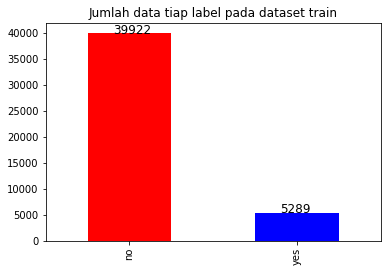

In [15]:
ax = dataset_train['y'].value_counts().plot.bar(color=['r','b'])
plt.title("Jumlah data tiap label pada dataset train")
for p in ax.patches:
    b = p.get_bbox()
    ax.annotate(str(p.get_height()), ((b.x0 + b.x1)/2 - .1, p.get_height() * 1.),fontsize=12)

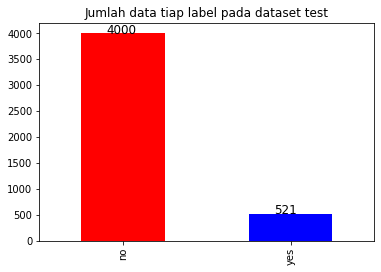

In [16]:
ax = dataset_test['y'].value_counts().plot.bar(color=['r','b'])
plt.title("Jumlah data tiap label pada dataset test")
for p in ax.patches:
    b = p.get_bbox()
    ax.annotate(str(p.get_height()), ((b.x0 + b.x1)/2 - .1, p.get_height() * 1.),fontsize=12)

In [17]:
train_index = [i for i in dataset_train.drop(columns=['y']).columns]
dataset_train.groupby(by=train_index)["y"].value_counts().unstack().reset_index().sort_values(by=["no"], ascending=True).head()

y,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,no,yes
2,18,student,single,primary,no,1944,no,no,telephone,10,aug,122,3,-1,0,unknown,1.0,NaN
30043,45,entrepreneur,married,primary,no,1953,yes,no,unknown,15,may,95,3,-1,0,unknown,1.0,NaN
30044,45,entrepreneur,married,primary,no,2418,yes,no,unknown,14,may,120,1,-1,0,unknown,1.0,NaN
30045,45,entrepreneur,married,primary,no,5315,yes,yes,cellular,15,may,262,2,-1,0,unknown,1.0,NaN
30046,45,entrepreneur,married,secondary,no,-479,yes,no,cellular,30,jul,167,2,-1,0,unknown,1.0,NaN


In [18]:
cek_no_yes_max = dataset_train.groupby(by=["age", "job", "marital", "education", "balance", "housing", "loan", "month" , "duration"])["y"].value_counts().unstack().reset_index()

In [19]:
cek_no_yes_max.loc[cek_no_yes_max['no'].ge(1.0) &cek_no_yes_max['yes'].ge(1.0)]

y,age,job,marital,education,balance,housing,loan,month,duration,no,yes


##Data Preprocessing

mengubah column y, dengan nilai 0 menunjukan *NO* dan nilai 1 menunjukan *YES*

In [20]:
dataset_train['target'] = dataset_train.loc[:, 'y'].apply(lambda x : 0 if x == "no" else 1)

dataset_train.drop(columns=["default", "contact",	"day", "campaign",	"pdays",	"previous", "poutcome", "y"], inplace=True)

In [21]:
dataset_test['target'] = dataset_test.loc[:, 'y'].apply(lambda x : 0 if x == "no" else 1)

dataset_test.drop(columns=["default", "contact",	"day", "campaign",	"pdays",	"previous", "poutcome", "y"], inplace=True)

dataset train ini merupakan dataframe pandas, split data train dengan ratio 80:20 . 20 % untuk validasi

In [22]:
train, val = dataframe_split(dataset_train, ratio = 0.2, shuffle=1)

In [23]:
print(len(train), 'training examples')
print(len(val), 'validation examples')

36169 training examples
9042 validation examples


##Data Preparation

membuat dataset

In [24]:
batch_size = 128

train_ds = dataframe_imbalanced_to_dataset(train, batch_size=batch_size, repeat=5)
val_ds = dataframe_imbalanced_to_dataset(val, batch_size=batch_size, repeat=6)
test_ds = dataframe_to_dataset(dataset_test, batch_size=batch_size)

cek data

In [25]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of marital:', train_features['job'])
print('A batch of targets:', label_batch )

Every feature: ['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan', 'month', 'duration']
A batch of marital: tf.Tensor(
[[b'management']
 [b'blue-collar']
 [b'retired']
 [b'self-employed']
 [b'management']
 [b'management']
 [b'services']
 [b'admin.']
 [b'technician']
 [b'blue-collar']
 [b'management']
 [b'blue-collar']
 [b'blue-collar']
 [b'entrepreneur']
 [b'management']
 [b'admin.']
 [b'entrepreneur']
 [b'retired']
 [b'technician']
 [b'technician']
 [b'technician']
 [b'blue-collar']
 [b'technician']
 [b'technician']
 [b'management']
 [b'admin.']
 [b'student']
 [b'technician']
 [b'management']
 [b'admin.']
 [b'technician']
 [b'management']
 [b'management']
 [b'blue-collar']
 [b'management']
 [b'management']
 [b'student']
 [b'admin.']
 [b'management']
 [b'management']
 [b'housemaid']
 [b'housemaid']
 [b'technician']
 [b'retired']
 [b'admin.']
 [b'management']
 [b'services']
 [b'student']
 [b'blue-collar']
 [b'blue-collar']
 [b'student']
 [b'management']
 [b'blue-collar'

test preprocessing

In [26]:
test_job_col = train_features['job']
test_job_layer = categories_preprocessing(name='job',
                                        dataset=train_ds,
                                        dtype='string')
test_job_layer(test_job_col).numpy()

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [27]:
test_duration_col = train_features['duration']
test_duration_layer = numeric_preprocessing(name='duration',
                                            dataset=train_ds,
                                            num_bins=32)
test_duration_layer(test_duration_col)

<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[ 0.22395158],
       [-0.03667781],
       [-0.42195603],
       [ 0.02564661],
       [-0.8837233 ],
       [-0.44461945],
       [ 1.0936605 ],
       [-0.22081813],
       [ 0.5724017 ],
       [ 0.17862472],
       [-0.7930696 ],
       [-0.7165805 ],
       [ 1.3174618 ],
       [ 1.3089631 ],
       [-0.34263402],
       [-1.0055392 ],
       [-0.776072  ],
       [-0.5522707 ],
       [-0.2576462 ],
       [-0.6230939 ],
       [-0.55793655],
       [-0.9772099 ],
       [ 0.79903597],
       [ 0.03697832],
       [-0.3284694 ],
       [-0.7335781 ],
       [-0.79023665],
       [-0.6514232 ],
       [-0.6060963 ],
       [-0.86105984],
       [-0.08200466],
       [-0.7109147 ],
       [-0.07350587],
       [-0.8100672 ],
       [ 0.4194236 ],
       [-0.62875974],
       [-0.7137476 ],
       [ 1.3174618 ],
       [-0.48711336],
       [-0.82989764],
       [ 1.4591082 ],
       [-0.05367538],
       [-0.39645967],
    

membagikan column berdasarkan numeric atau categorical integer atau string

In [28]:
numeric_keys = ["balance", "duration"]
categorical_integer_keys = ["age"]
categorical_string_keys = ["job", "marital", "education", "housing", "loan", "month"]
all_inputs = []
all_preprocessors = []

In [29]:
for numeric in numeric_keys:
  input = tf.keras.Input(shape=(1,), name=numeric, dtype="int64")
  num_layer = numeric_preprocessing(name=numeric, dataset=train_ds, num_bins=32)
  num_preprocessor = num_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(num_preprocessor)

In [30]:
for categorical in categorical_string_keys:
  input = tf.keras.Input(shape=(1,), name=categorical, dtype="string")
  cat_layer = categories_preprocessing(name=categorical, dataset=train_ds, dtype="string")
  cat_preprocessor = cat_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(cat_preprocessor)

In [31]:
for categorical_int in categorical_integer_keys:
  input = tf.keras.Input(shape=(1,), name=categorical_int, dtype="int64")
  cat_int_layer = categories_preprocessing(name=categorical_int, dataset=train_ds, dtype="int64")
  cat_int_preprocessor = cat_int_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(cat_int_preprocessor)

In [32]:
all_inputs, all_preprocessors

([<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'balance')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'duration')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'job')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'marital')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'education')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'housing')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'loan')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'month')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'age')>],
 [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_2')>,
  <KerasTensor: shape=(None, 13) dtype=float32 (created by layer 'category_encoding_1')>,
  <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'cat

##Model

In [42]:
all_features = tf.keras.layers.concatenate(all_preprocessors)
x = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.0001))(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.0001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.0001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model = tf.keras.Model(all_inputs, output)

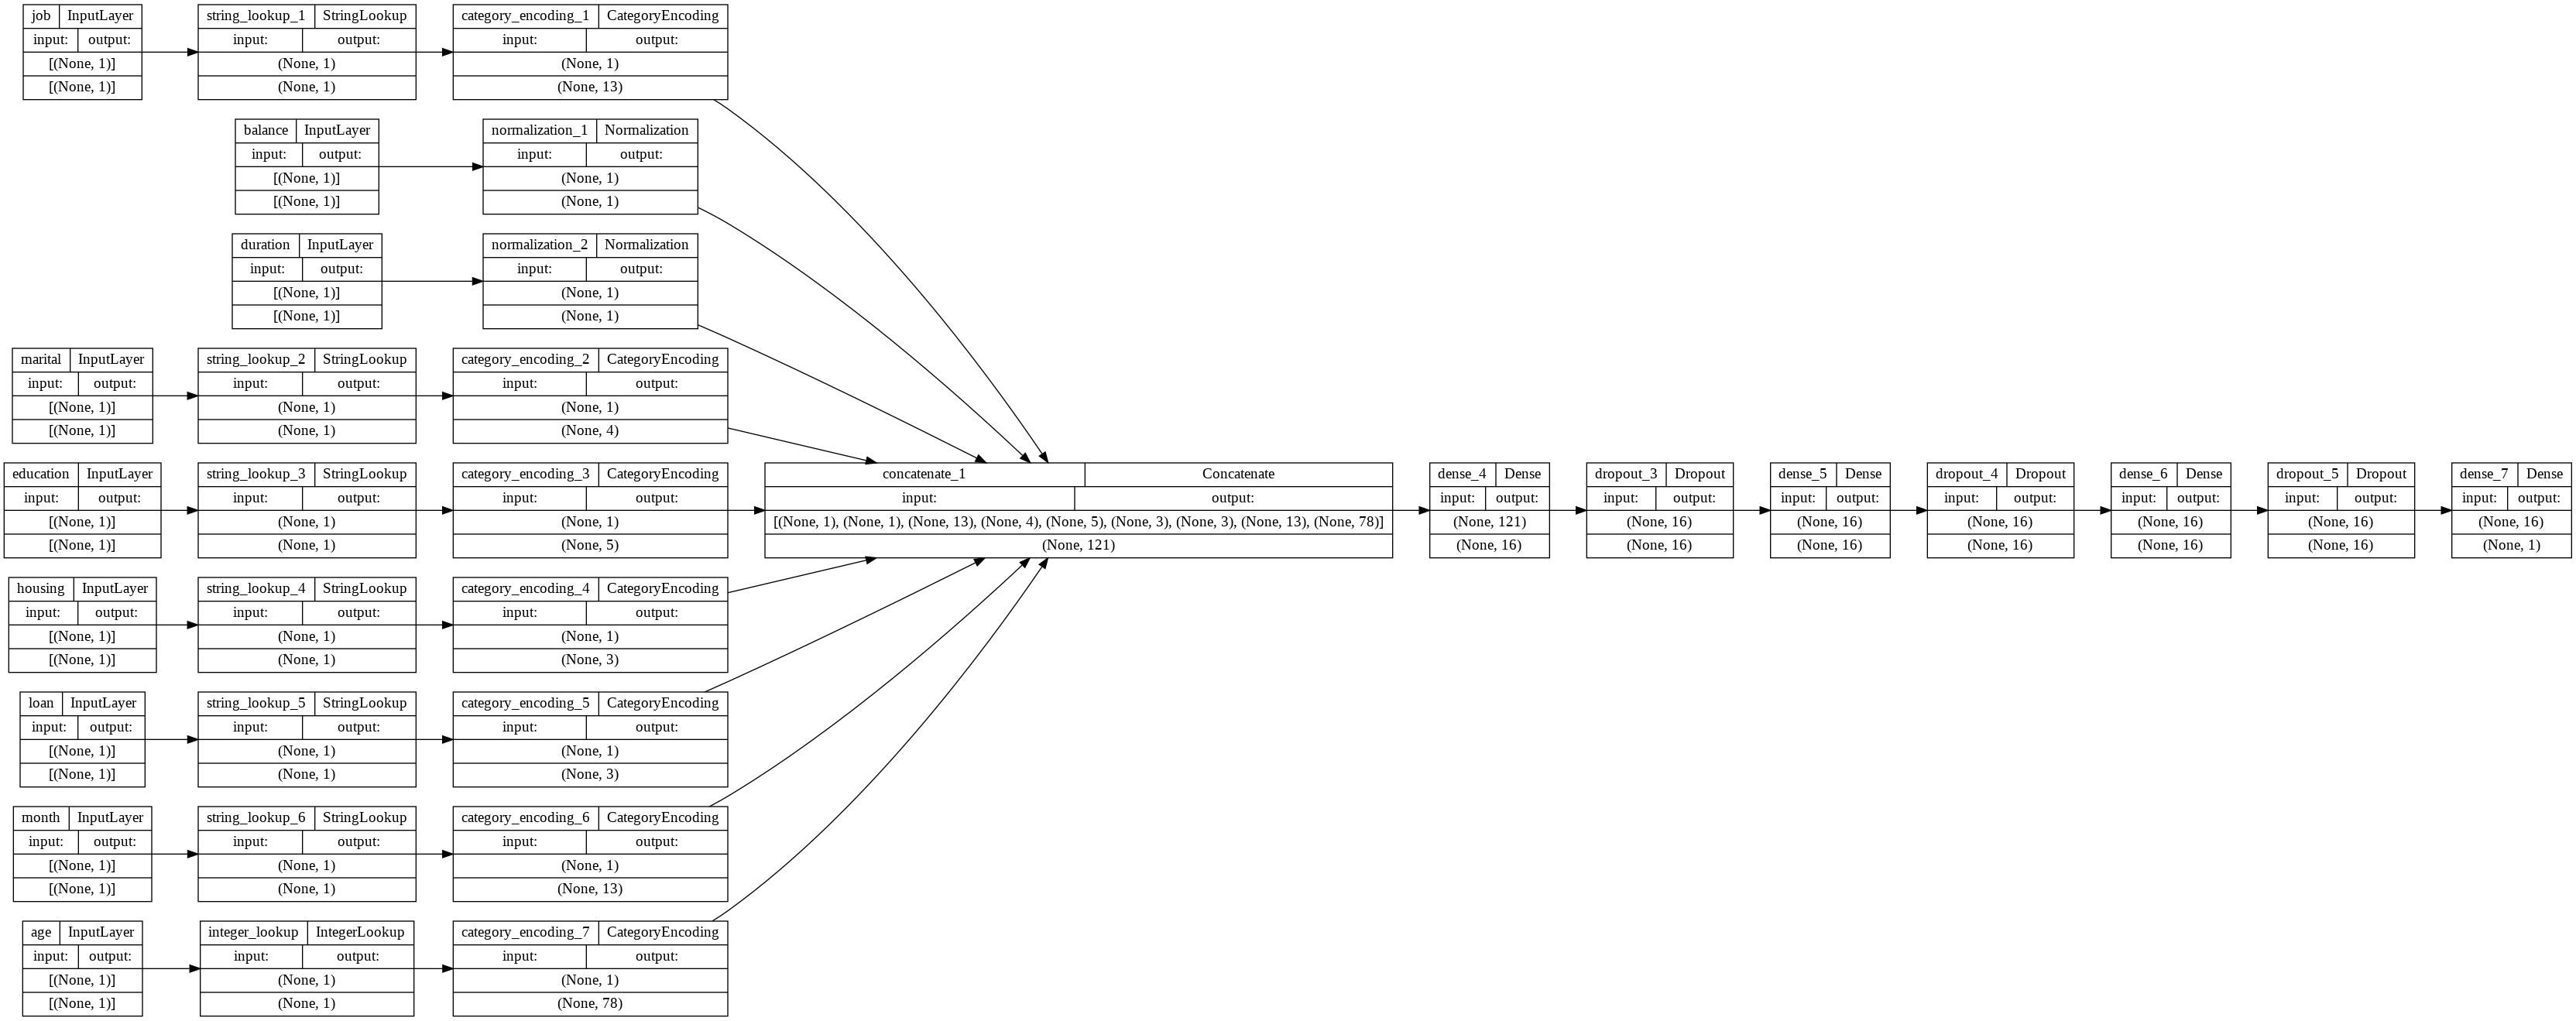

In [43]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [44]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [45]:
es_loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
es_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[es_loss, es_val_loss])

Epoch 1/100
2568/2568 [==============================] - 46s 17ms/step - loss: 0.4971 - tp: 138582.0000 - fp: 43577.0000 - tn: 116148.0000 - fn: 30378.0000 - accuracy: 0.7750 - precision: 0.7608 - recall: 0.8202 - auc: 0.8476 - prc: 0.8321 - val_loss: 1.2237 - val_tp: 44646.0000 - val_fp: 41136.0000 - val_tn: 6726.0000 - val_fn: 84.0000 - val_accuracy: 0.5548 - val_precision: 0.5205 - val_recall: 0.9981 - val_auc: 0.8843 - val_prc: 0.8476
Epoch 2/100
2568/2568 [==============================] - 43s 17ms/step - loss: 0.4440 - tp: 147893.0000 - fp: 39777.0000 - tn: 119948.0000 - fn: 21067.0000 - accuracy: 0.8149 - precision: 0.7880 - recall: 0.8753 - auc: 0.8764 - prc: 0.8529 - val_loss: 1.1094 - val_tp: 44646.0000 - val_fp: 39666.0000 - val_tn: 8196.0000 - val_fn: 84.0000 - val_accuracy: 0.5707 - val_precision: 0.5295 - val_recall: 0.9981 - val_auc: 0.8863 - val_prc: 0.8512
Epoch 3/100
2568/2568 [==============================] - 42s 16ms/step - loss: 0.4356 - tp: 148735.0000 - fp: 3969

##Model Evaluation

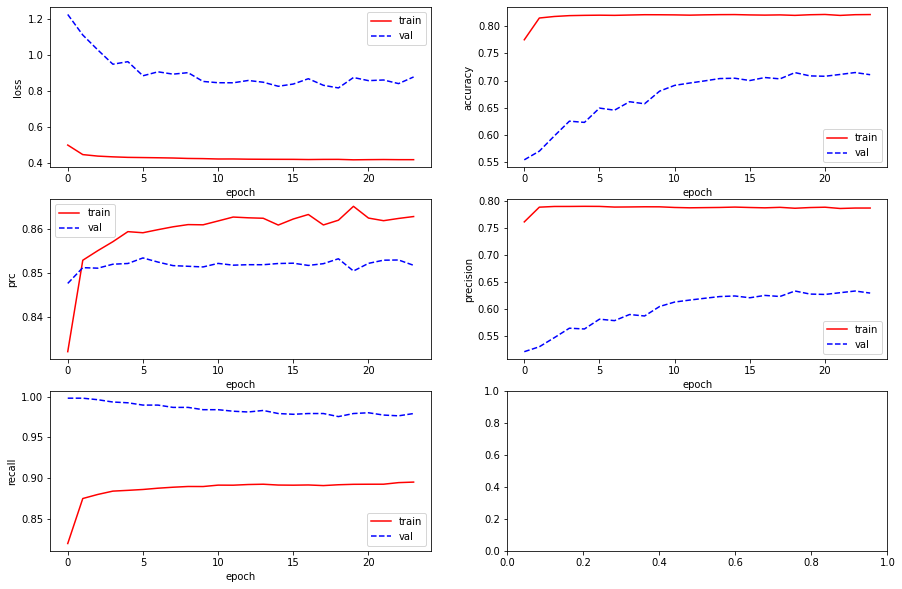

In [46]:
metric = ['loss', 'accuracy', 'prc', 'precision', 'recall']
plot_metric(3,2, history, metric)

In [47]:
predict_test = model.predict(test_ds)
test_ds_unbach = test_ds.unbatch()
label_test = [i[1] for i in list(test_ds_unbach.as_numpy_iterator())]


36/36 [==============================] - 0s 9ms/step - loss: 1.3775 - tp: 519.0000 - fp: 2211.0000 - tn: 1789.0000 - fn: 2.0000 - accuracy: 0.5105 - precision: 0.1901 - recall: 0.9962 - auc: 0.8935 - prc: 0.4673
loss :  1.3774547576904297
tp :  519.0
fp :  2211.0
tn :  1789.0
fn :  2.0
accuracy :  0.5105065107345581
precision :  0.19010989367961884
recall :  0.9961612224578857
auc :  0.8934691548347473
prc :  0.46730685234069824
Legitimate Transactions Detected (True Negatives):  1789
Legitimate Transactions Incorrectly Detected (False Positives):  2211
Fraudulent Transactions Missed (False Negatives):  2
Fraudulent Transactions Detected (True Positives):  519
Total Fraudulent Transactions:  521


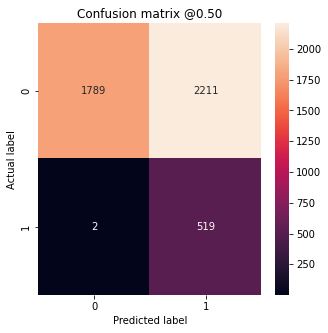

In [48]:
model_evaluate = model.evaluate(test_ds)
for name_metric, value_evaluate in zip(model.metrics_names, model_evaluate):
  print(name_metric, ': ', value_evaluate)

plot_confution_matrix(label_test, predict_test)

In [49]:
dataset_test.sort_values(by=["target"], ascending=True).head()

,age,job,marital,education,balance,housing,loan,month,duration,target
0,30,unemployed,married,primary,1787,no,no,oct,79,0
2906,34,management,single,tertiary,0,no,no,aug,191,0
2907,44,technician,married,tertiary,1707,no,no,aug,406,0
2908,35,technician,married,secondary,13658,yes,no,dec,220,0
2909,39,admin.,married,secondary,406,no,no,jul,253,0


##Predict

In [50]:
sample = {
    'age': 35,
    'job': 'technician',
    'marital': 'married',
    'education': 'tertiary',
    'balance': 1707,
    'housing': 'no',
    'loan': 'no',
    'month': 'aug',
    'duration': 406
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    f"Probabilitas untuk berlangganan deposito berjangka adalah {round(100 * predictions[0][0], 2)} % "
    f"untuk setuju"
)

Probabilitas untuk berlangganan deposito berjangka adalah 96.41 % untuk setuju
